***
# <font color=red>Building a Forecaster using AutoMLx</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle AutoMLx Team </font></p>

***

AutoMLx Fairness Demo version 23.4.1.

Copyright © 2023, Oracle and/or its affiliates.

Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl/

## Overview of this Notebook

In this notebook we will build a forecaster using the Oracle AutoMLx tool for three real-world datasets. We explore the various options available in the Oracle AutoMLx Forecasting module, allowing the user to control the AutoMLx training process. We finally evaluate the statistical forecasting algorithms using in-built visualization tools. Note that contrary to other tasks like Classification, Regression or Anomaly detection, the AutoMLx package does not yet support explainability for forecasting tasks.

---
## Prerequisites

  - Experience level: Novice (Python and Machine Learning)
  - Professional experience: Some industry exprience
  
Compatible conda pack: [Oracle AutoMLx v23.4 for CPU on Python 3.10 (version 1.0)](oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/Oracle_AutoMLx_v23.4_for_CPU_on_Python_3.10/1.0/automlx234_p310_cpu_x86_64_v1)

---

## Business Use

Forecasting uses historical time series data as input to make informed estimates of future trends. Learning accurate statistical forecasting model requires expertise in data science and statistics. This process typically comprises of: 
- Preprocess dataset (clean, impute, engineer features, normalize).
- Pick an appropriate model for the given dataset and prediction task at hand.
- Tune the chosen model’s hyperparameters for the given dataset.

These steps are significantly time consuming and heavily rely on data scientist expertise. Unfortunately, to make this problem harder, the best feature subset, model, and hyperparameter choice widely varies with the dataset and the prediction task. Hence, there is no one-size-fits-all solution to achieve reasonably good model performance. Using a simple Python API, AutoMLx can quickly (faster) jump-start the datascience process with an accurately-tuned model and appropriate features for a given prediction task.

## Table of Contents

- <a href='#setup'>0. Setup</a>
- <a href='#univariate'>1. Univariate time series
    - <a href='#load-m4'>1.1. Load the M4 Forecasting Competition dataset
    - <a href='#task'>1.2. Split data into train and test for the forecasting task</a>
    - <a href='#Engine'>1.3. Set the engine and deprecation warnings</a>
    - <a href='#provider'>1.4. Create an instance of Oracle AutoMLx</a>
    - <a href='#default'>1.5. Train a forecasting model using AutoMLx</a>
    - <a href='#forecast'>1.6. Generate and visualize forecasts</a>
    - <a href='#analysis'>1.7. Analyze the AutoMLx optimization process</a>
        - <a href='#algorithm-selection'>1.7.1 Algorithm Selection</a>
        - <a href='#hyperparameter-tuning'>1.7.2 Hyperparameter Tuning</a>
    - <a href='#load-data-air'>1.8. Load the Airline Dataset</a>
    - <a href='#scoringstr'>1.9. Specify a different score metric for optimization</a>
    - <a href='#WFCV'>1.10. Specify the number of cross-validation (CV) folds</a>
- <a href='#multi'>2. Multivariate time series</a>
    - <a href='#multi-generating'>2.1. Generate the data</a>
    - <a href='#multi-fitting'>2.2. Train a model using Oracle AutoMLx</a>
    - <a href='#multi-making'>2.3. Make predictions</a>
    - <a href='#multi-visualization'>2.4. Visualization</a>
- <a href='#ref'>References</a>

<a id='setup'></a>
## Setup

Basic setup for the Notebook.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Load the required modules.

In [1]:
import time
import datetime
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sktime.forecasting.model_selection import temporal_train_test_split

plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["font.size"] = 15

# Deprecated automl check
try:
    import automl

    print(
        "⚠️  The 'automl' module is no longer supported. Please update your conda environment to use latest supported version of AutoMLx to run this notebook."
    )
except ImportError:
    pass

# Recommended AutoMLx
import automlx
from automlx import init

<a id='univariate'></a>
# Univariate time series
The Oracle AutoMLx solution for forecasting can process both univariate and multivariate time series. We start by displaying an example of use for univariate time series, and will adress multivariate data at the end of this notebook.<br> 

<a id='load-m4'></a>
### Load the M4 Forecasting Competition dataset 


We fetch a  univariate timeseries from the repository of the [M4 forecasting competition](https://mofc.unic.ac.cy/m4/).

In [44]:
import sys
import oracledb
try:
    conn = oracledb.connect(user="ADMIN", password="WORKSHOPsec2019##", dsn="(description= (retry_count=20)(retry_delay=3)(address=(protocol=tcps)(port=1522)(host=adb.sa-saopaulo-1.oraclecloud.com))(connect_data=(service_name=jy2otyfomimhaoc_dbtest_high.adb.oraclecloud.com))(security=(ssl_server_dn_match=yes)))",
                              config_dir="/home/datascience/fast-track-ml/wallet",
                              wallet_location="/home/datascience/fast-track-ml/wallet",
                              wallet_password="WORKSHOPsec2019##")
    print("Connection successful!")
except Exception as e:
    print("Connection failed!")
    sys.exit(1)

Connection successful!


In [2]:
m4_url = "https://github.com/Mcompetitions/M4-methods/raw/master/Dataset/Train/Weekly-train.csv"
m4_metadata_url = (
    "https://github.com/Mcompetitions/M4-methods/raw/master/Dataset/M4-info.csv"
)

all_series = pd.read_csv(m4_url, index_col=0)  # consists of thousands of series
metadata_csv = pd.read_csv(
    m4_metadata_url, index_col=0
)  # describes their datetime index

In [46]:
all_series.to_csv("/home/datascience/m4_weekly_train.csv")


We select a series from the finance sector with weekly collection frequency. M4 dataset requires additional preprocessing to reconstruct the timeseries.

In [3]:
series_id = "W142"
series_metadata = metadata_csv.loc[series_id]
series_values = all_series.loc[series_id]

# drop NaNs for the time period where data wasn't recorded
series_values.dropna(inplace=True)

# retrieve starting date of recording and series length to generate the datetime index
start_date = pd.to_datetime(series_metadata.StartingDate)
future_dates = pd.date_range(start=start_date, periods=len(series_values), freq="W")
y = pd.DataFrame(
    series_values.to_numpy(),
    index=future_dates,
    columns=[series_metadata.category + "_" + series_id],
)

We can now visualize the last 200 weeks of data we have on hand.

<Axes: ylabel='Weekly Series W142'>

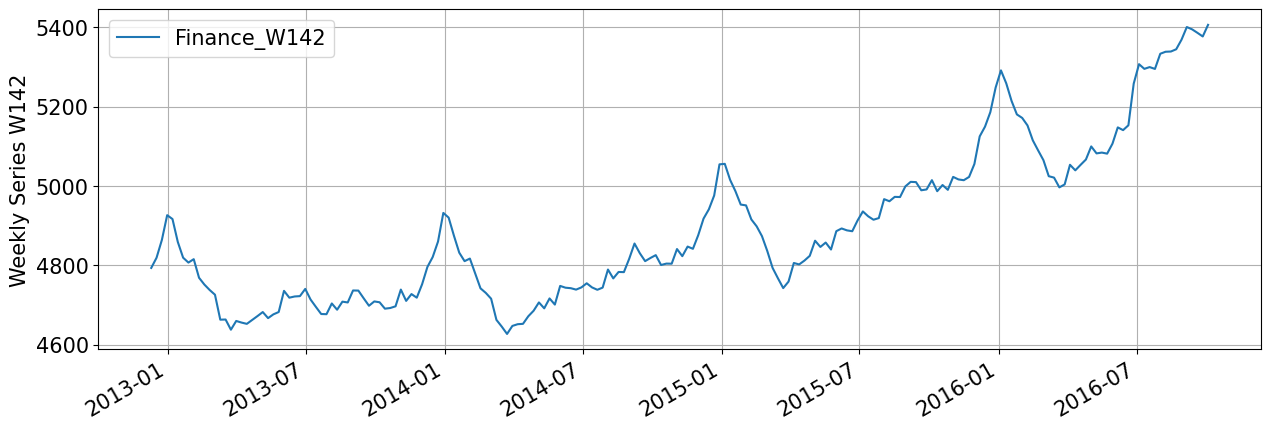

In [4]:
y = y.tail(n=200)  # approximately 4 years of data
y.plot(ylabel="Weekly Series " + series_id, grid=True)

One must ensure that the data points are in a Pandas DataFrame, sorted in chronological order.

In [5]:
print(y.index)
print("Time Index is", "" if y.index.is_monotonic_increasing else "NOT", "monotonic.")
print("Train datatype", type(y))

DatetimeIndex(['2012-12-09 12:00:00', '2012-12-16 12:00:00',
               '2012-12-23 12:00:00', '2012-12-30 12:00:00',
               '2013-01-06 12:00:00', '2013-01-13 12:00:00',
               '2013-01-20 12:00:00', '2013-01-27 12:00:00',
               '2013-02-03 12:00:00', '2013-02-10 12:00:00',
               ...
               '2016-07-31 12:00:00', '2016-08-07 12:00:00',
               '2016-08-14 12:00:00', '2016-08-21 12:00:00',
               '2016-08-28 12:00:00', '2016-09-04 12:00:00',
               '2016-09-11 12:00:00', '2016-09-18 12:00:00',
               '2016-09-25 12:00:00', '2016-10-02 12:00:00'],
              dtype='datetime64[ns]', length=200, freq='W-SUN')
Time Index is  monotonic.
Train datatype <class 'pandas.core.frame.DataFrame'>


<a id='task'></a>
### Split data into train and test for the forecasting task
As can be seen above, the data contains 200 weekly recorded values over the past 5 years. We will try to predict electricity consumption for the last 0.5 year of data (26 data points), using the previous years as training data. Hence, we separate the dataset into training and testing sets using Temporal train-test split, which ensures that the continuity of the input time series is preserved. Each point in the series represents a month, so we will hold out the last 26 points as test data.

In [6]:
y_train, y_test = temporal_train_test_split(y, test_size=26)
print("Training length: ", len(y_train), " Testing length: ", len(y_test))

Training length:  174  Testing length:  26


We see that the train data ranges from December 2012 to April 2016, while the test data ranges from April to October 2016.

In [7]:
print("y_train", y_train)
print("\ny_test", y_test)

y_train                      Finance_W142
2012-12-09 12:00:00      4793.269
2012-12-16 12:00:00      4818.969
2012-12-23 12:00:00      4863.783
2012-12-30 12:00:00      4926.357
2013-01-06 12:00:00      4916.616
...                           ...
2016-03-06 12:00:00      5024.759
2016-03-13 12:00:00      5021.153
2016-03-20 12:00:00      4996.524
2016-03-27 12:00:00      5004.032
2016-04-03 12:00:00      5053.536

[174 rows x 1 columns]

y_test                      Finance_W142
2016-04-10 12:00:00      5039.544
2016-04-17 12:00:00      5053.420
2016-04-24 12:00:00      5066.860
2016-05-01 12:00:00      5099.887
2016-05-08 12:00:00      5082.291
2016-05-15 12:00:00      5084.340
2016-05-22 12:00:00      5081.651
2016-05-29 12:00:00      5106.797
2016-06-05 12:00:00      5147.906
2016-06-12 12:00:00      5140.993
2016-06-19 12:00:00      5153.210
2016-06-26 12:00:00      5258.369
2016-07-03 12:00:00      5307.455
2016-07-10 12:00:00      5295.631
2016-07-17 12:00:00      5300.088
2016-07-

<a id='Engine'></a>
### Setting the engine and deprecation warnings
The AutoMLx pipeline offers the function `init`, which allows to initialize the parallelization engine. 

In [8]:
init(engine="ray")

[2025-11-22 19:01:50,543] [automlx.backend] Overwriting ray session directory to /tmp/ya4fc1jc/ray, which will be deleted at engine shutdown. If you wish to retain ray logs, provide _temp_dir in ray_setup dict of engine_opts when initializing the AutoMLx engine.


<a id='provider'></a>
### Create an instance of Oracle AutoMLx

The Oracle AutoMLx solution automatically provides a tuned forecasting pipeline that best models the given training dataset and a prediction task at hand. Here the dataset can be any univariate time-series.

AutoMLx for Forecasting consists of three main modules: 
- **Preprocessing**
    - Impute any missing values using back fill or forward fill mechanisms to ensure input has a well-defined and consistent frequency.
    - Identify seasonalities present in the data by detrending and analyzing the Autocorrelation Function (ACF) of the series.
    - Decide appropriate number of cross-validation (CV) folds and the forecast horizons based on the datetime frequency of data.
- **Algorithm Selection**: Identify the right algorithm for a given dataset, choosing from the following:
    - NaiveForecaster - Naive and Seasonal Naive method
    - ThetaForecaster - Equivalent to Simple Exponential Smoothing (SES) with drift
    - ExpSmoothForecaster - Holt-Winters' damped method
    - STLwESForecaster - Seasonal Trend LOESS (locally weighted smoothing) with Exponential Smoothing substructure
    - STLwARIMAForecaster - Seasonal Trend LOESS (locally weighted smoothing) with ARIMA substructure
    - SARIMAForecaster - Seasonal Autoregressive Integrated Moving Average
    - ETSForecaster - Error, Trend, Seasonality (ETS) Statespace Exponential Smoothing
    - ProphetForecaster (optional) - Facebook Prophet. Only available if installed locally with `pip install fbprophet`
    - OrbitForecaster (optional) - Uber Orbit model with Exogenous Variables. (Available if a supported version is installed)
    - VARMAXForecaster - Vector AutoRegressive Moving Average with Exogenous Variables (Available for multivariate datasets)
    - DynFactorForecaster - Dynamic Factor Models in state-space form with Exogenous Variables (Available for multivariate datasets)
- **Hyperparameter Tuning** 
    - Find the right model parameters that maximize score for the given dataset. 

These pieces are readily combined into a simple AutoMLx pipeline which automates the entire forecasting process with minimal user input/interaction. One can then evaluate and visualize the forecast produced by the selected model, and optionally the other tuned models.

<a id='default'></a>
### Train a forecasting model using Oracle AutoMLx

The AutoMLx API is quite simple to work with. We first create an instance of the pipeline. Next, the training data is passed to the `fit()` function which successively executes the previously mentioned modules.

The generated model can then be used for forecasting tasks. By default, we use the negative of symmetric mean absolute percentage error (sMAPE)  scoring metric to evaluate the model performance. The parameter `n_algos_tuned` sets the number of algorithms whose hyperparameters are fully tuned. For highest accuracy results, it is recommended to set this value to >=2 and preferably to 8 such that all models are fully tuned.

In [9]:
est1 = automlx.Pipeline(task="forecasting", n_algos_tuned=2)
est1.fit(X=None, y=y_train)

print("Selected model: {}".format(est1.selected_model_))
print("Selected model params: {}".format(est1.selected_model_params_))

[2025-11-22 19:01:55,159] [automlx.data_transform] Number of simple differencing orders required: d = 1
[2025-11-22 19:01:55,164] [automlx.data_transform] Seasonal Periodicities; from decomposed/adjusted: [52, 35, 1]
[2025-11-22 19:01:55,206] [automlx.interface] Dataset shape: (174,2)
[2025-11-22 19:01:55,307] [automlx.data_transform] Running preprocessing. Number of features: 3
[2025-11-22 19:01:55,429] [automlx.data_transform] Preprocessing completed. Took 0.123 secs
[2025-11-22 19:01:55,438] [automlx.process] Running Model Generation
[2025-11-22 19:01:55,499] [automlx] Provided model (VARMAXForecaster) is not supported.Supported models are: ['LGBMForecaster', 'ExtraTreesForecaster', 'ExpSmoothForecaster', 'NaiveForecaster', 'SARIMAXForecaster', 'STLwARIMAForecaster', 'ThetaForecaster', 'ProphetForecaster', 'ETSForecaster', 'STLwESForecaster', 'XGBForecaster']
[2025-11-22 19:01:55,499] [automlx] Provided model (DynFactorForecaster) is not supported.Supported models are: ['LGBMForecas

The selected model params indicate a good fit at sp (seasonal periodicity) of 52, which typically corresponds to a yearly seasonality for data that is weekly collected (i.e., there are 52 weeks in a year).

<a id='forecast'></a>
### Generating and visualizing forecasts
There are two interfaces that support generating future forecasts using the trained forecasting pipeline.
The preferred function, `forecast()`, accepts a user-input value for the number of periods to forecast into the future, i.e., relative to the end of the training series. It also accepts a significance level to generate prediction confidence intervals (CIs). When the methods support intervals, confidence intervals at 1-alpha are generated, e.g., significance level alpha=0.05 generates 95% confidence intervals.

In [10]:
summary_frame = est1.forecast(periods=len(y_test), alpha=0.05)

The `predict(X)` interface supports absolute index-based forecasts, but does not support confidence intervals (CIs). It also downcasts the index to int64. 

It should be utilized only when you want to get both in-sample predictions (predictions at timestamps that are part of the training set) and out-of-sample predictions (predictions at timestamps that are not in the training set). The X variable should be an empty dataframe containing only the requested timestamps as index. Here we request 5 in-sample model fit values and 5 out-of-sample forecasts.

In [11]:
future_index = y_train.index[-5:].union(y_test.index[:5])
print(future_index)

DatetimeIndex(['2016-03-06 12:00:00', '2016-03-13 12:00:00',
               '2016-03-20 12:00:00', '2016-03-27 12:00:00',
               '2016-04-03 12:00:00', '2016-04-10 12:00:00',
               '2016-04-17 12:00:00', '2016-04-24 12:00:00',
               '2016-05-01 12:00:00', '2016-05-08 12:00:00'],
              dtype='datetime64[ns]', freq='W-SUN')


In [15]:
est1.predict(X=pd.DataFrame(index=future_index))

,Finance_W142
2016-03-06 12:00:00,5016.287568
2016-03-13 12:00:00,5014.320189
2016-03-20 12:00:00,4998.966014
2016-03-27 12:00:00,5014.255115
2016-04-03 12:00:00,5029.184261
2016-04-10 12:00:00,5053.504557
2016-04-17 12:00:00,5068.277312
2016-04-24 12:00:00,5082.155767
2016-05-01 12:00:00,5107.187258
2016-05-08 12:00:00,5093.752885


AutoMLx provides a simple one-line tool to visualize forecasts and confidence intervals.

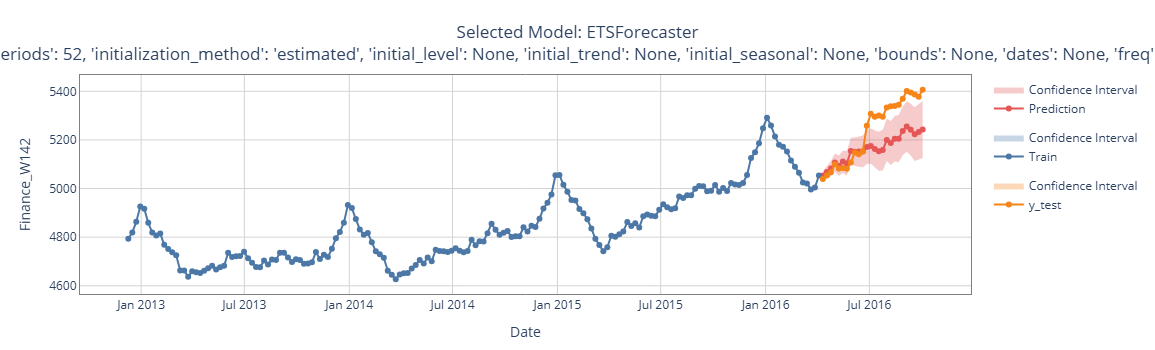

In [26]:
est1.plot_forecast(
    summary_frame,
    additional_frames=dict(y_test=y_test)
)


<a id='analysis'></a>
### Analyze the AutoMLx optimization process
During the AutoMLx process, a summary of the optimization process is logged. It consists of:
- Information about the training data 
- Information about the AutoMLx Pipeline, such as:
    - selected features that AutoMLx found to be most predictive in the training data;
    - selected algorithm that was the best choice for this data;
    - hyperparameters for the selected algorithm.

AutoMLx provides a `print_summary()` API to output all the different trials performed.

In [28]:
est1.print_summary()

,
Training Dataset size,"(174, 2)"
Validation Dataset size,None
CV,"TimeSeriesCV(Shuffle=False, Seed=7)"
Optimization Metric,neg_sym_mean_abs_percent_error
Selected Algorithm,ETSForecaster
Selected Hyperparameters,"{'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 52, 'initialization_method': 'estimated', 'initial_level': None, 'initial_trend': None, 'initial_seasonal': None, 'bounds': None, 'dates': None, 'freq': None, 'missing': 'none', 'start_params': None, 'maxiter': 1500, 'disp': -1, 'return_params': False}"
AutoMLx version,24.2.0
Python version,"3.8.16 (default, Jun 12 2023, 18:09:05) \n[GCC 11.2.0]"


,Step,# Samples,# Features,Algorithm,Hyperparameters,Score (neg_sym_mean_abs_percent_error),Runtime (Seconds),Memory Usage (GB),Finished
0,Model Selection,161,2,InputTargetDataTransformer_ETSForecaster,"{'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 52, 'initialization_method': 'estimated', 'initial_level': None, 'initial_trend': None, 'initial_seasonal': None, 'bounds': None, 'dates': None, 'freq': None, 'missing': 'none', 'start_params': None, 'maxiter': 1500, 'disp': -1, 'return_params': False}",-0.036,5.2164,0.2937,Sat Nov 22 19:02:08 2025
1,Model Selection,148,2,InputTargetDataTransformer_STLwARIMAForecaster,"{'seasonal_deg': 1, 'trend_deg': 1, 'low_pass_deg': 0, 'period': 52, 'arima_p': 2, 'arima_d': 1, 'arima_q': 2, 'arima_trend': 'n', 'concentrate_scale': True}",-0.0855,1.1906,0.3094,Sat Nov 22 19:02:14 2025
2,Model Selection,161,2,InputTargetDataTransformer_XGBForecaster,"{'differencing_order': 1, 'acf_local_maxima': '[52, 35, 17, 26, 22, 4, 48, 30, 13, 56, 39, 61, 44, 9, 65, 1]', 'use_X': True, 'n_estimators': 50, 'max_depth': 5}",-0.0951,3.8163,0.7483,Sat Nov 22 19:02:44 2025
3,Model Selection,161,2,InputTargetDataTransformer_ExtraTreesForecaster,"{'differencing_order': 1, 'acf_local_maxima': '[52, 35, 17, 26, 22, 4, 48, 30, 13, 56, 39, 61, 44, 9, 65, 1]', 'use_X': True, 'n_estimators': 40, 'min_samples_leaf': 0.030458}",-0.1252,8.4486,0.7303,Sat Nov 22 19:02:39 2025
4,Model Selection,161,2,InputTargetDataTransformer_LGBMForecaster,"{'differencing_order': 1, 'acf_local_maxima': '[52, 35, 17, 26, 22, 4, 48, 30, 13, 56, 39, 61, 44, 9, 65, 1]', 'use_X': True, 'max_depth': 4, 'n_estimators': 37}",-0.13,4.4911,0.7484,Sat Nov 22 19:02:47 2025
5,Model Selection,161,2,InputTargetDataTransformer_ThetaForecaster,"{'sp': 52, 'deseasonalize': False, 'initial_level': None}",-0.2091,0.5253,0.2912,Sat Nov 22 19:02:02 2025
6,Model Selection,161,2,InputTargetDataTransformer_ExpSmoothForecaster,"{'trend': 'add', 'damped_trend': True, 'seasonal': None, 'sp': 52, 'use_boxcox': False}",-0.2475,0.3615,0.2915,Sat Nov 22 19:02:03 2025
7,Model Selection,161,2,InputTargetDataTransformer_NaiveForecaster,"{'strategy': 'last', 'sp': 52, 'window_length': None}",-0.4494,1.0229,0.2786,Sat Nov 22 19:02:02 2025
8,Model Selection,161,2,InputTargetDataTransformer_STLwESForecaster,"{'seasonal_deg': 1, 'trend_deg': 1, 'low_pass_deg': 1, 'period': 52, 'es_trend': 'add', 'es_damped_trend': True, 'concentrate_scale': True}",-inf,1.3432,0.3012,Sat Nov 22 19:02:09 2025
9,Model Selection,135,2,InputTargetDataTransformer_SARIMAXForecaster,"{'sp': 52, 'p': 2, 'd': 1, 'q': 2, 'P': 1, 'D': 0, 'Q': 1, 'trend': 'n', 'use_X': True, 'enforce_stationarity': True, 'enforce_invertibility': True, 'method': 'lbfgs', 'disp': -1, 'concentrate_scale': False}",-inf,23.9154,0.3524,Sat Nov 22 19:02:34 2025


We also provide the capability to visualize the results of each stage of the AutoMLx pipeline. 

<a id='algorithm-selection'></a>
#### Algorithm Selection

The plot below shows the scores predicted by Algorithm Selection for each algorithm. Since negative sMAPE is used by default, higher values (closer to zero) are better. The horizontal line shows the average score across all algorithms. Algorithms with better score than average are colored turquoise, whereas those with worse score than average are colored teal. Here we can see that the `SARIMAXForecaster` algorithm achieved the best predicted score (orange bar), and is chosen for subsequent stages of the Pipeline.

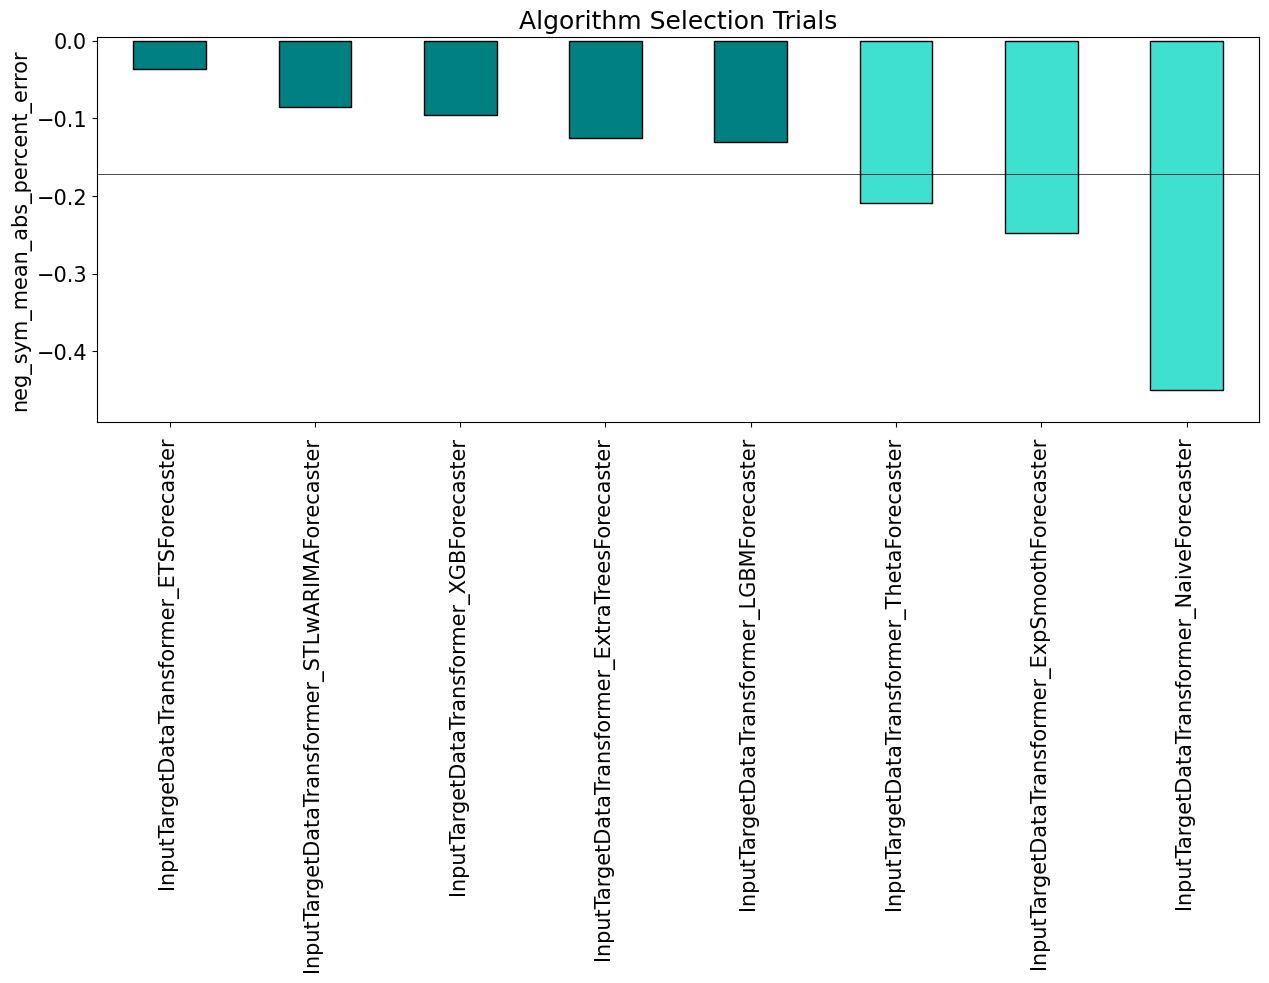

In [29]:
# Each trial is a tuple of
# (algorithm, no. samples, no. features, mean CV score, hyperparameters,
# all CV scores, total CV time (s), memory usage (Gb))
trials = est1.completed_trials_summary_[
    est1.completed_trials_summary_["Step"].str.contains("Model Selection")
]
name_of_score_column = f"Score ({est1._inferred_score_metric[0].name})"
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace=True)
scores = trials[name_of_score_column].tolist()
models = trials["Algorithm"].tolist()
colors = []

y_margin = 0.10 * (max(scores) - min(scores))
s = pd.Series(scores, index=models).sort_values(ascending=False)
s = s.dropna()
for f in s.keys():
    if f.strip() == est1.selected_model_.strip():
        colors.append("orange")
    elif s[f] >= s.mean():
        colors.append("teal")
    else:
        colors.append("turquoise")


fig, ax = plt.subplots(1)
ax.set_title("Algorithm Selection Trials")
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.set_ylabel(est1._inferred_score_metric[0].name)
s.plot.bar(ax=ax, color=colors, edgecolor="black")
ax.axhline(y=s.mean(), color="black", linewidth=0.5)
plt.show()

<a id='hyperparameter-tuning'></a>
#### Hyperparameter Tuning

Hyperparameter tuning is the last stage of the Oracle AutoMLx pipeline, and focuses on improving the chosen algorithm's score. We use a novel algorithm to search across many hyperparameter dimensions, and converge automatically when optimal hyperparameters are identified. Each trial in the graph below represents a particular hyperparameter combination for the selected model.

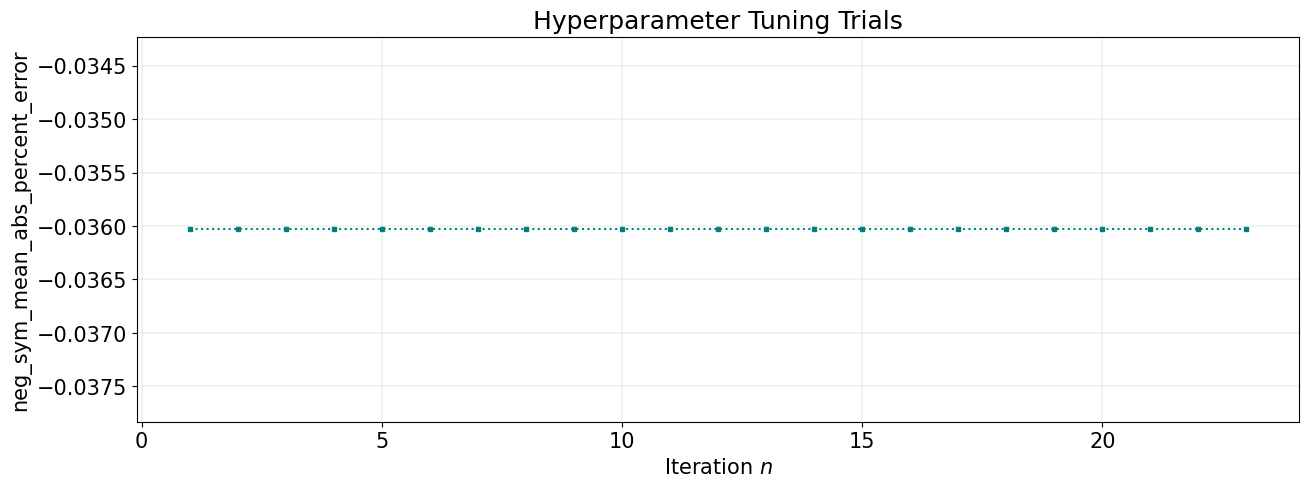

In [30]:
# Each trial is a row in a dataframe that contains
# Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
trials = est1.completed_trials_summary_[
    est1.completed_trials_summary_["Step"].str.contains("Model Tuning")
]
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace=True)
trials.drop(trials[trials["Finished"] == -1].index, inplace=True)
trials["Finished"] = trials["Finished"].apply(
    lambda x: time.mktime(
        datetime.datetime.strptime(x, "%a %b %d %H:%M:%S %Y").timetuple()
    )
)
trials.sort_values(by=["Finished"], ascending=True, inplace=True)
scores = trials[name_of_score_column].tolist()
score = []
score.append(scores[0])
for i in range(1, len(scores)):
    if scores[i] >= score[i - 1]:
        score.append(scores[i])
    else:
        score.append(score[i - 1])
y_margin = 0.10 * (max(score) - min(score))

fig, ax = plt.subplots(1)
ax.set_title("Hyperparameter Tuning Trials")
ax.set_xlabel("Iteration $n$")
ax.set_ylabel(est1._inferred_score_metric[0].name)
ax.grid(color="g", linestyle="-", linewidth=0.1)
ax.set_ylim(min(score) - y_margin, max(score) + y_margin)
ax.plot(range(1, len(trials) + 1), score, "k:", marker="s", color="teal", markersize=3)
plt.show()

We can also view all tuned algorithms, as well as their validation and testing performance. This provides a good sanity check for the decision making.

### Plotting is enabled for total models tuned = 2.
### Model_name		 Val_score 
ETSForecaster 	 -0.0360


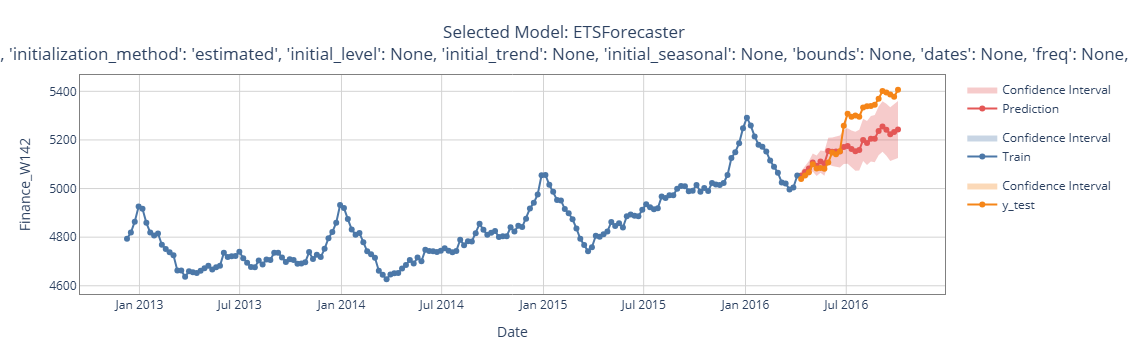

STLwARIMAForecaster 	 -0.0855


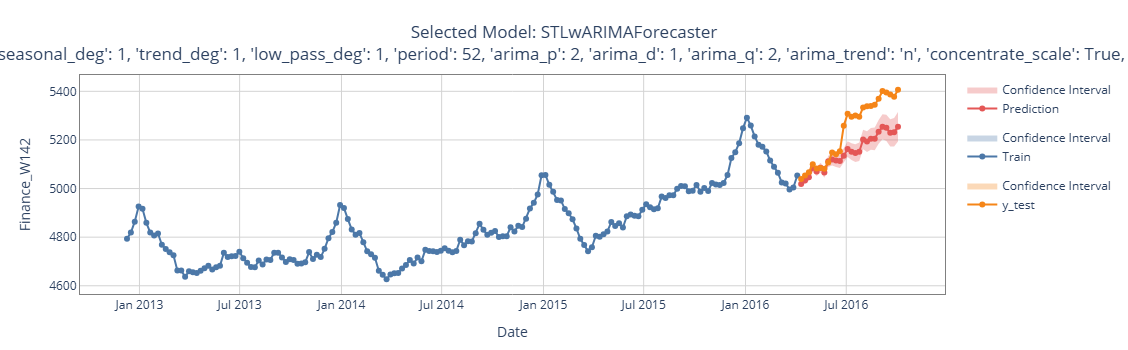

In [42]:
print(f"### Plotting is enabled for total models tuned = {len(est1.pipelines_)}.")
print("### Model_name\t\t Val_score ")

for pipeline in est1.pipelines_:

    # nome real do modelo no dataframe
    selected_alg = "InputTargetDataTransformer_" + pipeline.selected_model_.strip()

    # limpar espaços e comparar
    mask = est1.completed_trials_summary_["Algorithm"].str.strip() == selected_alg
    row = est1.completed_trials_summary_[mask]

    if row.empty:
        print("WARNING: modelo não encontrado:", selected_alg)
        continue

    val_score = row.iloc[0][name_of_score_column]

    print(pipeline.selected_model_, "\t", "%.4f" % val_score)

    # previsão
    summary_frame = pipeline.forecast(periods=len(y_test), alpha=0.05)
    summary_frame.index = y_test.index

    fig = pipeline.plot_forecast(summary_frame, additional_frames=dict(y_test=y_test))
    fig.show()


<a id='multi'></a>
## Multivariate time series

<a id='multi-generating'></a>
### Generate the data

We now display the use of the Oracle AutoMLx solution for multivariate timeseries. We load the 10-dimensional Lutkepohl2 dataset. We then restrict the data to 4 variables : two exogenous variables (variables that are independent on all other data variables), and two endogenous variables (variables that are dependent on some other data variables). The endogenous variables will be the target predictions of the pipeline, while the exogenous variables will be used solely as explanatory variables. 

In [32]:
dta = sm.datasets.webuse("lutkepohl2", "https://www.stata-press.com/data/r12/")
dta.index = dta.qtr
dta.index.freq = dta.index.inferred_freq
endog = dta.loc[
    "1960-04-01":"1978-10-01",
    [
        "dln_inv",
        "dln_inc",
    ],
]
exog = dta.loc["1960-04-01":"1978-10-01", ["dln_consump"]]
exog = sm.add_constant(exog)
exog.index = np.arange(
    0, len(exog)
)  # replace the datetime index with an integer index.
endog.index = np.arange(
    0, len(endog)
)  # replace the datetime index with an integer index.

We then split it using a temporal train-test split as done previously. Note that $X$ consists of the exogenous variables ('dln_consump' and another constant variable) while $y$ are the target variables ('dln_in' and 'dln_inc')

In [33]:
X_train_df, X_test_df = temporal_train_test_split(exog, train_size=0.9)
y_train_df, y_test_df = temporal_train_test_split(endog, train_size=0.9)

<a id='multi-fitting'></a>
### Train a model using Oracle AutoMLx

We can now fit the AutoMLx pipeline. For the multivariate forecasting task, the pipeline only considers two models : `VARMAX` and `DynFactor`.

In [34]:
custom_pipeline = automlx.Pipeline(
    task="forecasting",  # Supports 'classification', regression', 'anomaly_detection' and 'forecasting'
    model_list=[  # Specify the models you want the AutoMLx to consider
        "DynFactorForecaster",
        "VARMAXForecaster",
    ],
    n_algos_tuned=2,  # Choose how many models to tune
    preprocessing=True,  # Disable or enable Preprocessing step. Default to `True`
    search_space={},  # You can specify the hyper-parameters and ranges we search
    max_tuning_trials=2,  # The maximum number of tuning trials. Can be integer or Dict (max number for each model)
    score_metric="neg_sym_mean_abs_percent_error",  # Any scikit-learn metric or a custom function
    time_series_period=None,  # The period of time series
)

In [35]:
custom_pipeline.fit(X=X_train_df, y=y_train_df, cv=8)

[2025-11-22 19:52:17,286] [automlx.data_transform] Number of simple differencing orders required: d = 1
[2025-11-22 19:52:17,288] [automlx.data_transform] Seasonal Periodicities; from decomposed/adjusted: [1]
[2025-11-22 19:52:17,313] [automlx.interface] Dataset shape: (67,5)
[2025-11-22 19:52:17,353] [automlx.interface] Model Tune disabled.
[2025-11-22 19:52:17,372] [automlx.data_transform] Running preprocessing. Number of features: 6
[2025-11-22 19:52:17,479] [automlx.data_transform] Preprocessing completed. Took 0.108 secs
[2025-11-22 19:52:17,487] [automlx.process] Running Model Generation
[2025-11-22 19:52:17,530] [automlx.process] Model Generation completed.
[2025-11-22 19:52:17,540] [automlx.model_selection] Running Model Selection
[2025-11-22 19:52:17,540] [automlx.trials] Fewer models (2) than top_k (2) provided, skipping model selection
[2025-11-22 19:52:17,553] [automlx.interface] Re-fitting pipeline
[2025-11-22 19:52:19,012] [automlx.interface] AutoMLx completed.


The AutoMLx pipeline provides attributes to get the selected features, the chosen model, hyperparameters as well as the score on the test set.

In [36]:
test_score = custom_pipeline.score(X=X_test_df, y=y_test_df)

print("Ranked models: {}".format(custom_pipeline.ranked_models_))
print("Selected model: {}".format(custom_pipeline.selected_model_))
print("Selected model params: {}".format(custom_pipeline.selected_model_params_))
print(f"Score on test data : {test_score}")

Ranked models: ['DynFactorForecaster', 'VARMAXForecaster']
Selected model: DynFactorForecaster
Selected model params: {'k_factors': 1, 'error_order': 2, 'factor_order': 2, 'error_cov_type': 'diagonal', 'use_X': True, 'error_var': False, 'enforce_stationarity': True}
Score on test data : -0.13696298404695645


<a id='multi-making'></a>
### Make predictions

As mention in the univariate data case, there are two ways of making a prediction : 
- `forecast(k)` allows one to predict k steps after the end of the training data. It should be used when one wants to make out-of-sample predictions
- `predict(X)` returns predictions at the timestamps given as argument. It should be used when one wants to make in-sample predictions and out-of-sample predictions. It does not support confidence intervals.

In the cell below `predict()` is used on the last 5 timestamps of the train set, and all timestamps of the test set. `forecast()` is used to predict k steps after the training set, where k is the size of the test set.

In [37]:
y_pred = custom_pipeline.predict(pd.concat([X_train_df[-5:0], X_test_df], axis=0))
y_forecast = custom_pipeline.forecast(
    len(y_test_df), alpha=0.8, X=X_test_df
)  # out-of-sample forecast

The obtained forecast contains predictions for the two target variables, as well as lower and upper confidence intervals, for each timestamp in the test set.

In [38]:
y_forecast

,dln_inv,dln_inc,dln_inv_ci_lower,dln_inv_ci_upper
67,-0.003120,0.014758,-0.018650,0.012411
68,0.017576,0.013167,0.000655,0.034497
69,0.005082,0.015265,-0.015250,0.025414
70,0.003058,0.011910,-0.018976,0.025093
71,-0.007126,0.010479,-0.031220,0.016968
72,-0.004387,0.011608,-0.030034,0.021261
73,-0.012820,0.009531,-0.040018,0.014378
74,-0.021428,0.006440,-0.049969,0.007113


One can also directly compute the score of the tuned model on the test set, without needing to run `forecast()` or `predict()`.

In [39]:
print(
    "Tuned model testing score (negative sMAPE): ",
    custom_pipeline.score(X=X_test_df, y=y_test_df),
)

Tuned model testing score (negative sMAPE):  -0.13696298404695645


<a id='multi-visualization'></a>
### Visualization

Finally, when given as input the forecasted variables, the `plot_forecast()` method displays an interactive plot of the predictions (for each target variable) and confidence intervals.

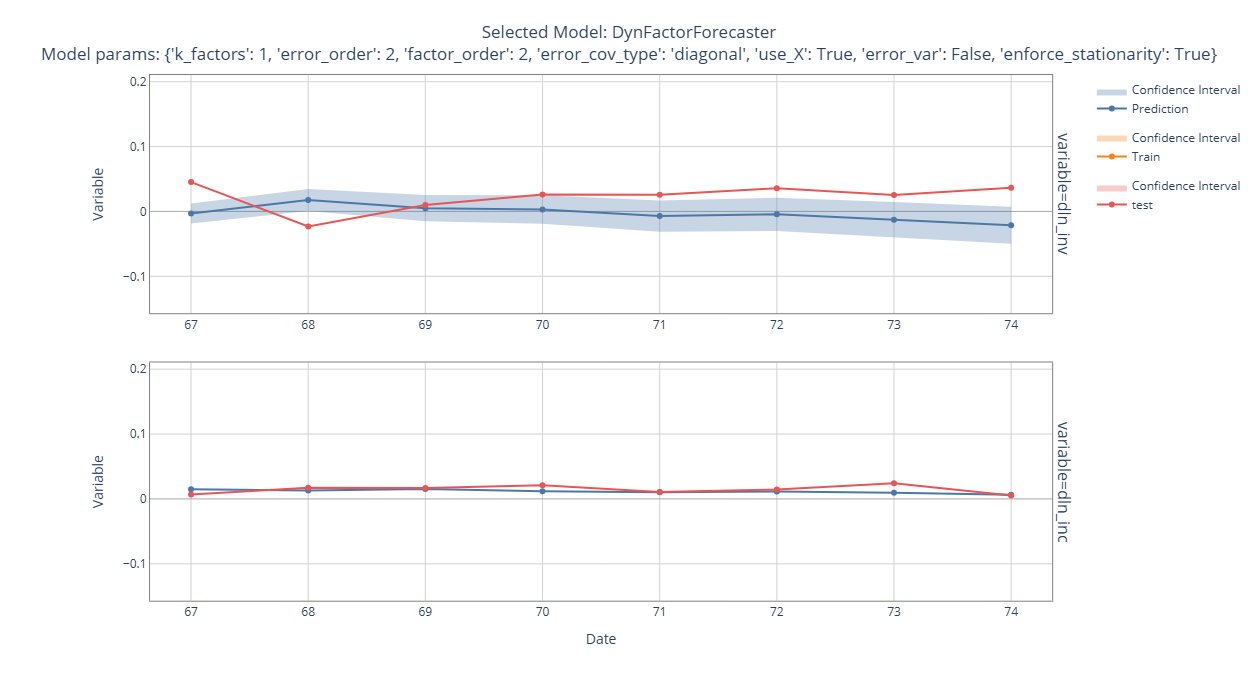

In [43]:
custom_pipeline.plot_forecast(y_forecast, additional_frames=dict(test=y_test_df))


<a id='ref'></a>
## References
* More examples and details: http://automl.oraclecorp.com/
* Oracle AutoMLx: http://www.vldb.org/pvldb/vol13/p3166-yakovlev.pdf
* sktime: https://www.sktime.org/en/latest/
* statsmodels: https://www.statsmodels.org/stable/index.html
* M4 Competition: https://mofc.unic.ac.cy/m4/
* Airline Dataset: https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.datasets.load_airline.html
